In [244]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Tree Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import pandas as pd
from sklearn.model_selection import train_test_split

In [245]:
dataset = pd.read_csv("./converted_dataset.csv")
dataset.columns = ['id', 'attribute_name', 'data_type', 'semantic_type', 'correct_data_type']

In [246]:
dataset = dataset[dataset.correct_data_type != ',']
dataset['correct_data_type'].unique()

array(['bigint', 'character_varying', 'timestamp', 'bytea', 'boolean',
       'uuid', 'json', 'inet', 'double_precision', 'date'], dtype=object)

## Data preparation

In [247]:
missing_values = dataset.isnull().sum()
dataset.dropna(inplace=True)

In [248]:
label_encoder = LabelEncoder()
encoded_data_types = label_encoder.fit_transform(dataset['correct_data_type'])
encoded_to_data_type = dict(zip(encoded_data_types, dataset['correct_data_type']))

# Print the mappings of encoded labels to data types
for encoded_label, data_type in encoded_to_data_type.items():
    print(f"Encoded Label: {encoded_label} -> Data Type: {data_type}")

Encoded Label: 0 -> Data Type: bigint
Encoded Label: 3 -> Data Type: character_varying
Encoded Label: 8 -> Data Type: timestamp
Encoded Label: 2 -> Data Type: bytea
Encoded Label: 7 -> Data Type: json
Encoded Label: 6 -> Data Type: inet
Encoded Label: 9 -> Data Type: uuid
Encoded Label: 1 -> Data Type: boolean
Encoded Label: 5 -> Data Type: double_precision
Encoded Label: 4 -> Data Type: date


In [249]:
pattern_rules = {
    'uuid': r'^(uuid)$',
    'bigint': r'^(id)$',
    'double_precision': r'^(amount)$',
    'date':  r'^(date)$',
    'time':  r'^(time)$',
    'timestamp': r'^(at|in|created|updated|verified|deleted|until|accessed|executed)$',
    'character_varying': r'^(name|description|text|email)$',
    'boolean': r'^(is|has|flag|enabled|disabled)$',
    'bytea': r'^(key)$',
    'jsonb': r'^(data)$', 
    'ip': r'^(inet)$'
}

dataset['attribute_name'] = dataset['attribute_name'].str.split('_')

## Hardcoded approach

In [250]:
# data_types = []
# attribute_names = dataset['attribute_name']
# for tokens in attribute_names:
#     # data_type = None
#     for token in tokens:
#         for rule, pattern in pattern_rules.items():
#             if re.match(pattern, token, re.IGNORECASE):
#                 data_type = rule
#                 break  
#     data_types.append(data_type)
# dataset['data_type'] = data_types
# test = dataset['attribute_name'] 
# print(dataset.head(100))

## RandomForestClassifier

In [258]:
attribute_names = dataset['attribute_name']
X = [" ".join(tokens) for tokens in attribute_names] # Convert token lists back to text
y = dataset['correct_data_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [252]:
classifier = RandomForestClassifier(n_estimators=50, random_state=42, bootstrap=True, class_weight=None, criterion='entropy',max_depth=None, max_features='auto', max_leaf_nodes=None)
classifier.fit(X_train_tfidf, y_train)
y_pred = classifier.predict(X_test_tfidf)

# Testing: what prediction does a model make for a given input (new_attribute)
new_attribute = "car_park_id"
new_attribute_tokens = new_attribute.split('_')
new_attribute_text = " ".join(new_attribute_tokens)
new_attribute_tfidf = vectorizer.transform([new_attribute_text])
predicted_data_type = classifier.predict(new_attribute_tfidf)
print(f"Predicted data type: {predicted_data_type[0]}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Predicted data type: bigint
Accuracy: 0.84
                   precision    recall  f1-score   support

           bigint       0.96      0.80      0.87        30
          boolean       0.00      0.00      0.00         1
            bytea       1.00      0.50      0.67         2
character_varying       0.59      0.95      0.73        21
             date       0.00      0.00      0.00         1
 double_precision       1.00      0.80      0.89         5
             json       1.00      0.75      0.86         4
        timestamp       1.00      0.93      0.96        29
             uuid       1.00      0.50      0.67         2

         accuracy                           0.84        95
        macro avg       0.73      0.58      0.63        95
     weighted avg       0.88      0.84      0.84        95



/Users/yura.kovbuz/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yura.kovbuz/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yura.kovbuz/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

## RandomForestClassifier with the use of Pattern Rules

In [253]:
def pattern_present(attribute, pattern):
    return int(bool(re.match(pattern, attribute, re.IGNORECASE)))

def add_pattern_features(X, pattern_rules):
    new_X = []
    for i, attribute in enumerate(X):
        feature_list = []
        for pattern in pattern_rules.values():
            feature = any(pattern_present(word, pattern) for word in attribute.split(' '))
            feature_list.append(feature)
        new_X.append(feature_list)
    return new_X

In [260]:
X_train_with_patterns = add_pattern_features(X_train, pattern_rules)
X_test_with_patterns = add_pattern_features(X_test, pattern_rules)

X_train_with_patterns = np.array(X_train_with_patterns)
X_test_with_patterns = np.array(X_test_with_patterns)

X_train_combined = np.concatenate([X_train_tfidf.toarray(), X_train_with_patterns], axis=1)
X_test_combined = np.concatenate([X_test_tfidf.toarray(), X_test_with_patterns], axis=1)

# Retrain the RandomForestClassifier with the combined features
classifier = RandomForestClassifier(n_estimators=100, random_state=42,bootstrap=True, class_weight=None, criterion='gini',max_depth=None, max_leaf_nodes=None)
classifier.fit(X_train_combined, y_train)
y_pred = classifier.predict(X_test_combined)

# Testing: what prediction does a model make for a given input (input_data)
input_data = "is_car"
input_data_tokens = input_data.split('_')
# input_data_tokens = [" ".join(tokens) for tokens in input_data_split]
input_data_tfidf = vectorizer.transform(input_data_tokens)  # Use the same TF-IDF vectorizer
input_data_pattern_features = add_pattern_features(input_data_tokens, pattern_rules)
input_data_pattern_features = np.array(input_data_pattern_features)
input_data_combined = np.concatenate([input_data_tfidf.toarray(), input_data_pattern_features], axis=1)

# Make predictions
predicted_data_type = classifier.predict(input_data_combined)

# Print the predicted data type
print(f"Predicted data type: {predicted_data_type[0]}")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Predicted data type: boolean
Accuracy: 0.85
                   precision    recall  f1-score   support

           bigint       0.96      0.80      0.87        30
          boolean       0.00      0.00      0.00         1
            bytea       1.00      0.50      0.67         2
character_varying       0.61      0.95      0.74        21
             date       0.00      0.00      0.00         1
 double_precision       1.00      0.80      0.89         5
             json       1.00      0.75      0.86         4
        timestamp       1.00      0.97      0.98        29
             uuid       1.00      0.50      0.67         2

         accuracy                           0.85        95
        macro avg       0.73      0.59      0.63        95
     weighted avg       0.88      0.85      0.85        95



/Users/yura.kovbuz/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yura.kovbuz/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yura.kovbuz/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## Data Visualisation

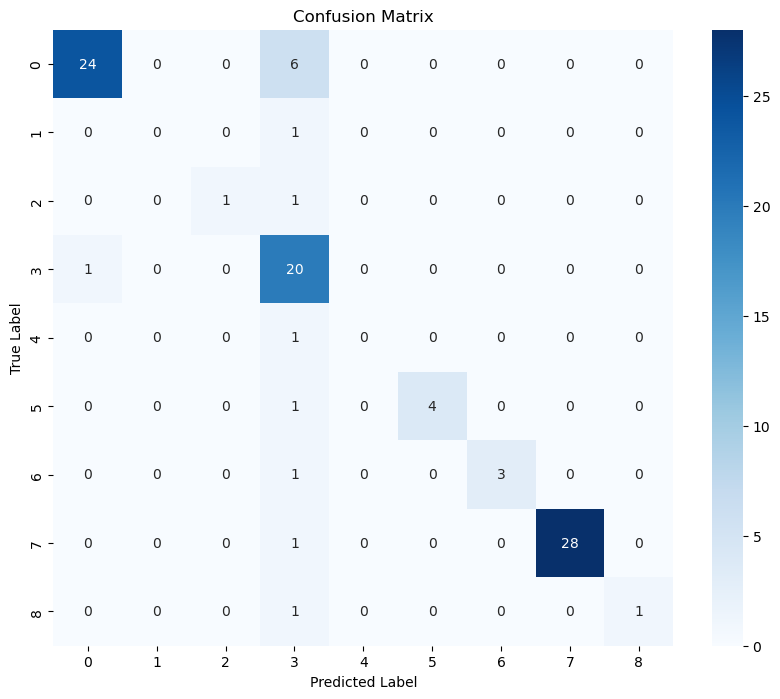

/Users/yura.kovbuz/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yura.kovbuz/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yura.kovbuz/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

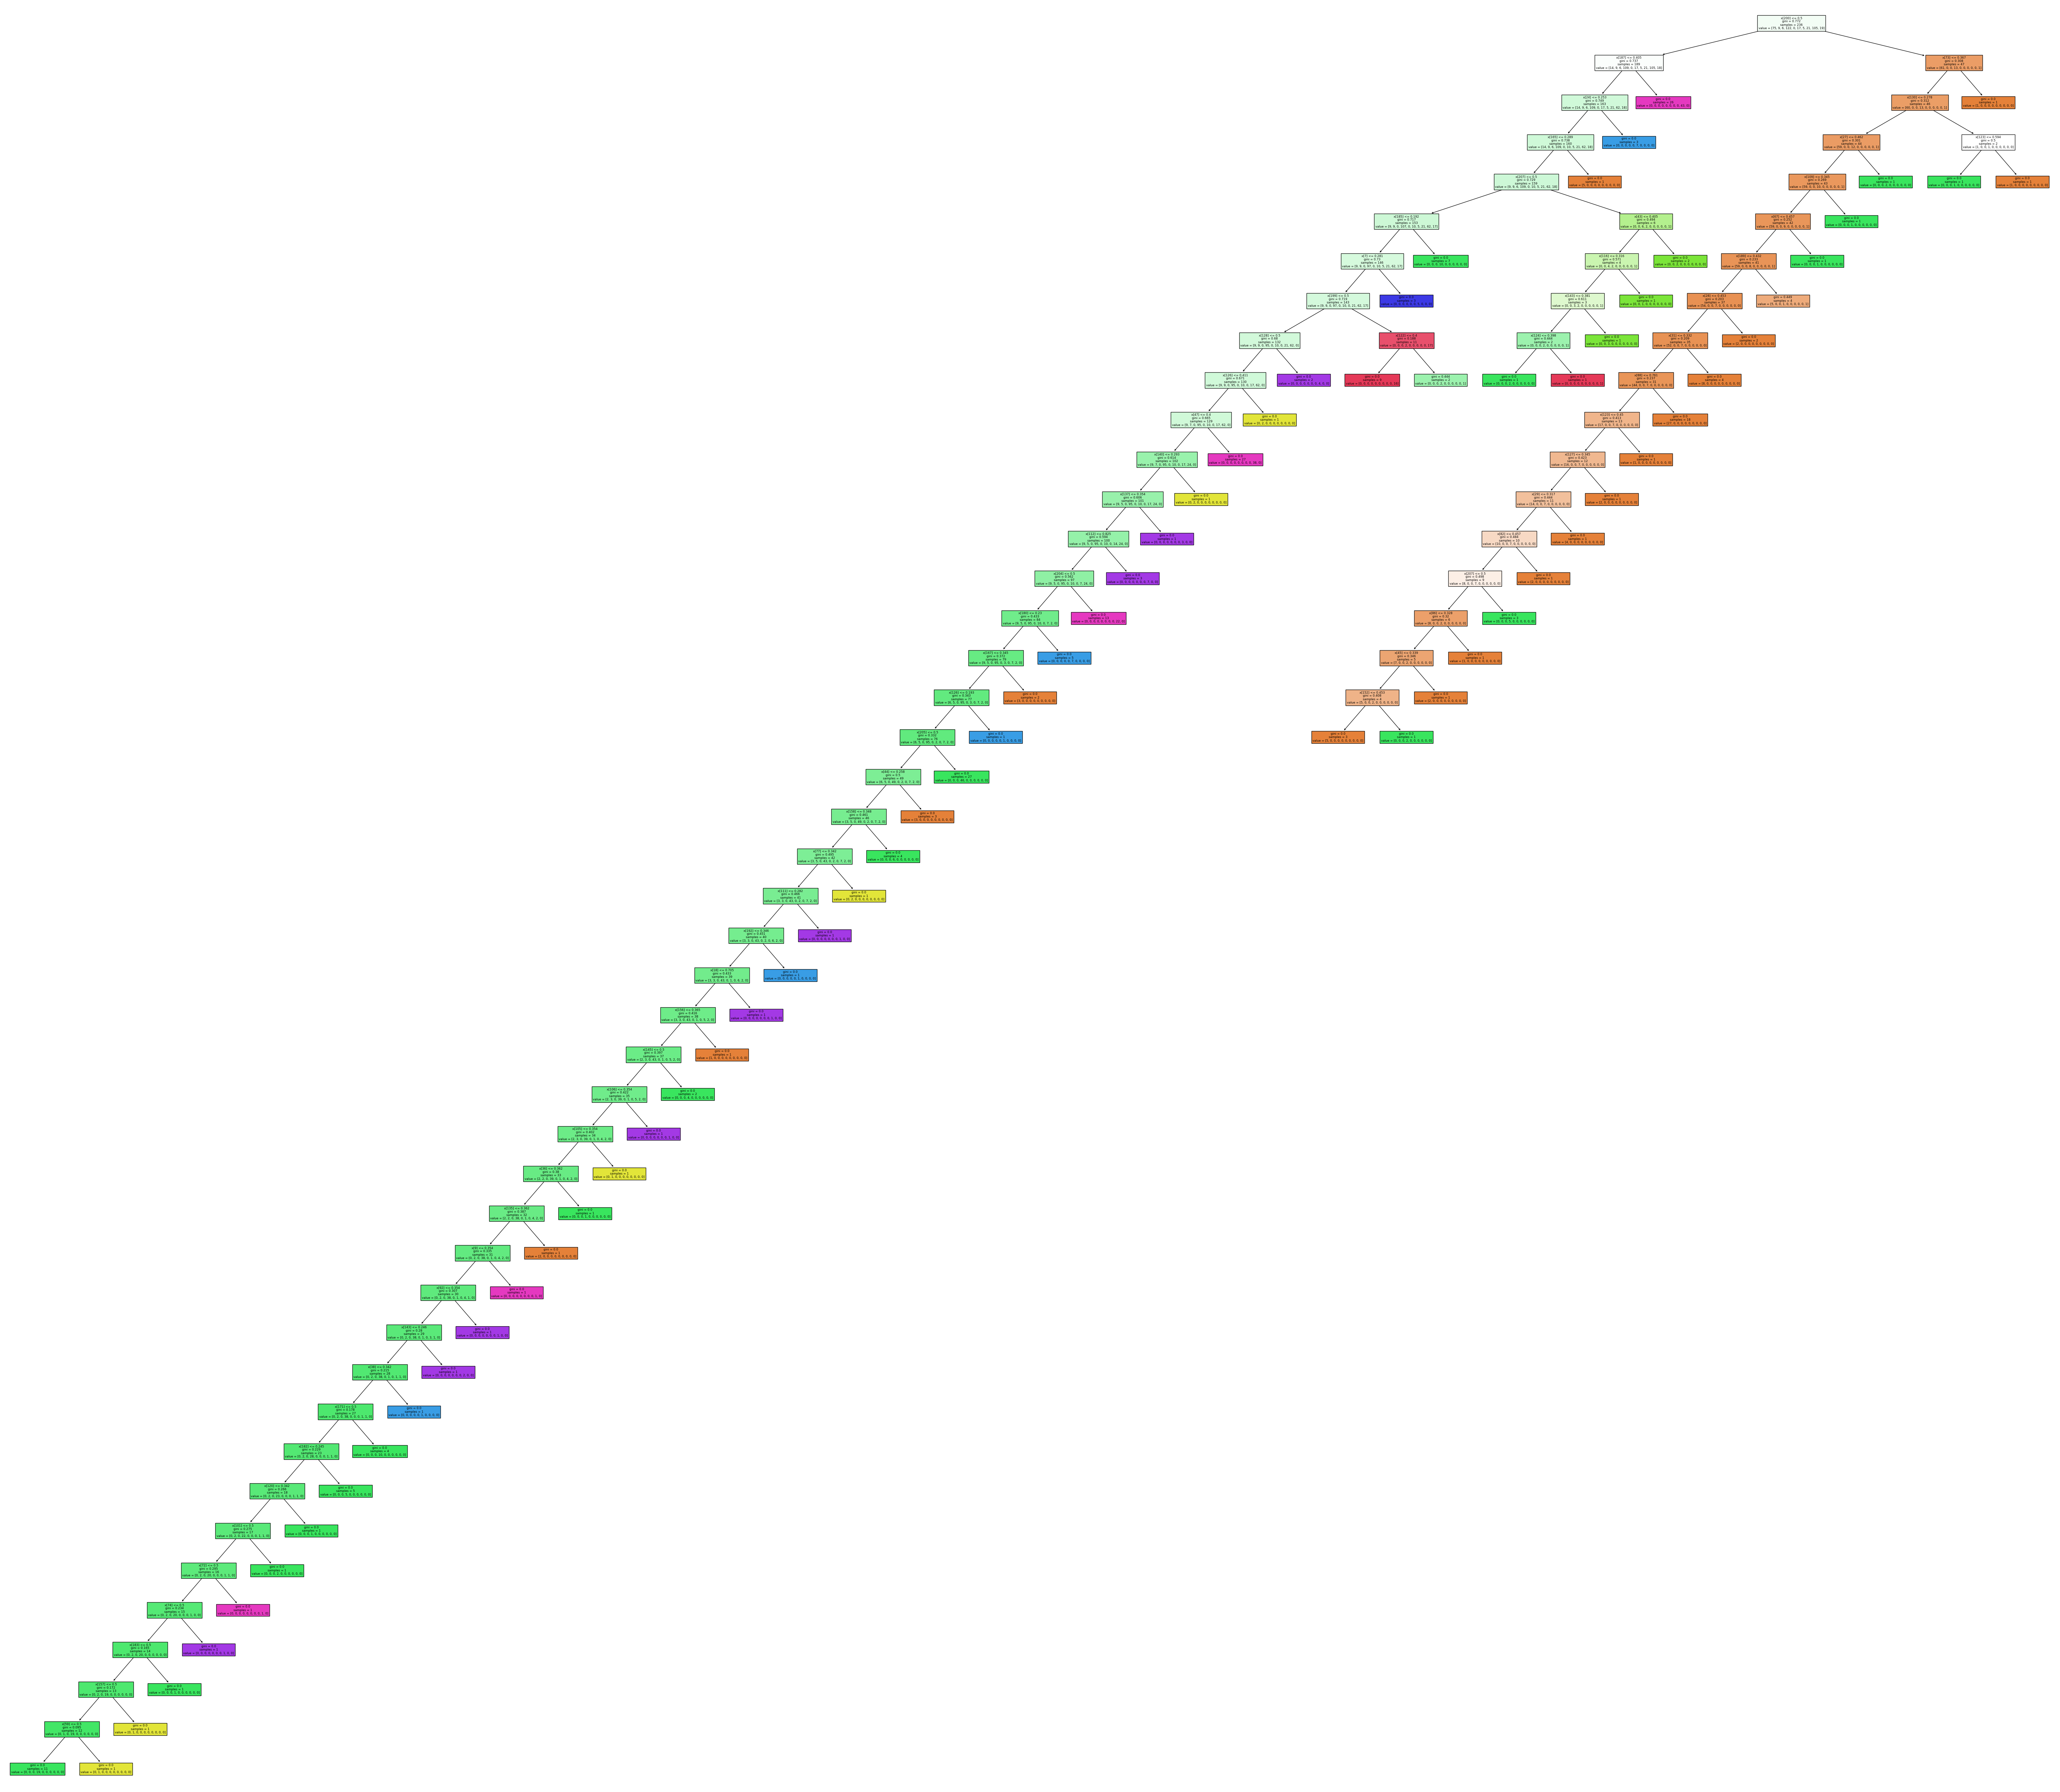

In [257]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report Visualization
report = classification_report(y_test, y_pred, output_dict=True)
data_types = list(report.keys())[:-3] 

precision = [report[data_type]['precision'] for data_type in data_types]
recall = [report[data_type]['recall'] for data_type in data_types]
f1 = [report[data_type]['f1-score'] for data_type in data_types]

plt.figure(figsize=(80, 70))
tree.plot_tree(classifier.estimators_[3], filled=True)
plt.show()